## 刚度矩阵的组装

run boxmesh2d with time: 0.0003347440001562063
4
[[2 3 0]
 [1 0 3]]
[0.5 0.5]
[[0.33333333 0.33333333 0.33333333]] [1.]
(1, 2, 3, 2)
(2, 3, 3)
[[[2 2 2]
  [3 3 3]
  [0 0 0]]

 [[1 1 1]
  [0 0 0]
  [3 3 3]]]
[[[2 3 0]
  [2 3 0]
  [2 3 0]]

 [[1 0 3]
  [1 0 3]
  [1 0 3]]]
( 2 , 2 ) 1.0
( 2 , 3 ) -0.5
( 2 , 0 ) -0.5
( 3 , 2 ) -0.5
( 3 , 3 ) 0.5
( 3 , 0 ) 0.0
( 0 , 2 ) -0.5
( 0 , 3 ) 0.0
( 0 , 0 ) 0.5
( 1 , 1 ) 1.0
( 1 , 0 ) -0.5
( 1 , 3 ) -0.5
( 0 , 1 ) -0.5
( 0 , 0 ) 0.5
( 0 , 3 ) 0.0
( 3 , 1 ) -0.5
( 3 , 0 ) 0.0
( 3 , 3 ) 0.5
[[ 1.  -0.5 -0.5  0. ]
 [-0.5  1.   0.  -0.5]
 [-0.5  0.   1.  -0.5]
 [ 0.  -0.5 -0.5  1. ]]
run serial_construct_matrix with time: 0.0013456370002131735
[[ 1.  -0.5 -0.5  0. ]
 [-0.5  1.   0.  -0.5]
 [-0.5  0.   1.  -0.5]
 [ 0.  -0.5 -0.5  1. ]]
(1, 1, 3)
(2, 3, 3)
[[ 1.  -0.5 -0.5  0. ]
 [-0.5  1.   0.  -0.5]
 [-0.5  0.   1.  -0.5]
 [ 0.  -0.5 -0.5  1. ]]
(2, 3, 3)
[[-0.33333333 -0.16666667 -0.16666667 -0.33333333]
 [ 0.          0.          0.          0.       

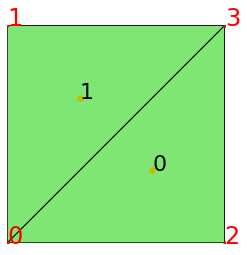

In [36]:
import numpy as np
import matplotlib.pyplot as plt

from fealpy.mesh import MeshFactory
from fealpy.functionspace import LagrangeFiniteElementSpace
from scipy.sparse import csr_matrix

mf = MeshFactory()
mesh = mf.boxmesh2d([0, 1, 0, 1], nx=1, ny=1, meshtype='tri')


space = LagrangeFiniteElementSpace(mesh, p=1)
gdof = space.number_of_global_dofs()
print(gdof)

cell = mesh.entity('cell')
node = mesh.entity('node')

cell2dof = space.cell_to_dof()
print(cell2dof)

cellmeasure = mesh.entity_measure('cell')
print(cellmeasure)

qf = mesh.integrator(1, 'cell')
bcs, ws = qf.get_quadrature_points_and_weights()

print(bcs, ws)

gphi = space.grad_basis(bcs)
print(gphi.shape)

A = np.einsum('i, ijkl, ijml, j->jkm', ws, gphi, gphi, cellmeasure) #(2,3,3)
print(A.shape)

I = np.broadcast_to(cell2dof[:, :, None], shape=A.shape)
print(I)

J = np.broadcast_to(cell2dof[:, None, :], shape=A.shape)
print(J)

# I and J 是只读的， 不能修改

for i ,j, val in zip(I.flat, J.flat, A.flat):
    print('(',i, ',', j,')', val)
    
A = csr_matrix((A.flat, (I.flat, J.flat)), shape=(gdof, gdof)) # (gdof, gdof)
print(A.toarray())

A = space.stiff_matrix()
print(A.toarray())

phi = space.basis(bcs) #(1,1,3)
print(phi.shape)

M = np.einsum('i, ijk, ijm, j->jkm', ws, phi, phi, cellmeasure)
print(M.shape)

M = csr_matrix((M.flat,(I.flat, J.flat)), shape=(gdof, gdof))
print(A.toarray())

b = np.array([1.0, 1.0], dtype=np.float64)
B = np.einsum('i, q, ijkq, ijm, j->jkm',ws,b,gphi,phi,cellmeasure)
print(B.shape)

B = csr_matrix((B.flat, (I.flat, J.flat)), shape=(gdof, gdof))
print(B.toarray())

B = space.convection_matrix(c=b)
print(B.toarray())

# 组装负载向量
from fealpy.decorator import cartesian

@cartesian
def f(p):
    x = p[..., 0]
    y = p[..., 1]
    return np.exp(x**2 + y**2)

qf = mesh.integrator(2, 'cell')
bcs, ws =qf.get_quadrature_points_and_weights()
print(bcs,ws)

phi = space.basis(bcs) #(6,1,3)
print(phi.shape)

ps = mesh.bc_to_point(bcs)
print(ps.shape)
print(ps)

print('ps[..., 0]:\n', ps[..., 0]) # x
print('ps[..., 1]:\n', ps[..., 1]) #y

val = f(ps)
print(ps.shape)

bb = np.einsum('i, ij, ijk, j->jk',ws, val, phi, cellmeasure)
print(bb.shape)

F = np.zeros(gdof, dtype=np.float64)
np.add.at(F, cell2dof, bb)
print('F:\n', F)
'''
print('bb:\n', bb)
print('cell2dof:\n', cell2dof)
'''
F2 = space.source_vector(f)
print('F2:\n', F2)


fig = plt.figure()
axes = fig.gca()
mesh.add_plot(axes)
mesh.find_node(axes, showindex='True', fontsize=24)
mesh.find_cell(axes, showindex='True', fontsize=22)
plt.show()